In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import date, timedelta, datetime

import calendar
from dateutil.relativedelta import relativedelta

In [2]:

class Curve:
  def __init__(self, futures):
    futures = futures.T
    f_exp_dates = self.apply(futures[0], self.get_fut_date)
    f_start_dates = np.apply_along_axis(
        lambda x: datetime(x[1], x[0],  1) + relativedelta(months=-3), 
        0, f_exp_dates)
    f_price = futures[1]
    libor = 1 - f_price/100
    df = 1/(1 + 1/4 * libor) #все евродоллар фьючерсы сроком 3 месяца
    self.f_start_interp = self.apply(f_start_dates, self.get_timestamp)
    self.df = df.astype(float)

  def get_fut_date(self, name):
    month = {
        'F': 1, 'G': 2, 'H': 3,
        'J': 4, 'K': 5, 'M': 6,
        'N': 7, 'Q': 8, 'U': 9,
        'V': 10, 'X': 11, 'Z': 12,
            }
    name = name[0]       
    f_m = month[name[-2]]
    f_y = int('202' + name[-1])
    return (f_m, f_y)

  def get_timestamp(self, date):
    date = date[0]
    date = datetime(date.year, date.month, date.day)
    return calendar.timegm(date.timetuple())

  def apply(self, data, func):
    return np.apply_along_axis(func, 1, data.reshape(-1, 1)).T

  def get_df_curve(self, dates):
    dates = dates.astype(datetime)
    dates_interp = self.apply(dates, self.get_timestamp)
    df_interp = np.interp(dates_interp, self.f_start_interp, self.df)
    #не совсем понимаю, что должна показывать discount curve:
    #дисконт фактор для интервала 0, t_i, для точки t_i или 
    #показывать df для периода 3 месяца с момента t_i
    df_cum = np.cumprod(df_interp)
    result_option_1 = np.stack([dates, df_cum]).T
    result_option_2 = np.stack([dates, df_interp]).T
    result_option_1.T[0] = result_option_1.T[0].astype(np.datetime64) 
    return (result_option_1, result_option_2)

In [3]:
data = pd.read_csv('forward.csv', sep=';')
data = data[['MONTH', 'PRIOR']].dropna()
data.loc[6, 'PRIOR'] = np.mean([data.loc[5, 'PRIOR'], data.loc[7, 'PRIOR']])
data

,MONTH,PRIOR
0,GEX1,99.8475
1,GEZ1,99.8100
2,GEF2,99.8250
3,GEG2,99.8150
4,GEH2,99.7800
5,GEJ2,99.7300
6,GEK2,99.6775
7,GEM2,99.6250
8,GEU2,99.4400
9,GEZ2,99.2200


In [4]:
start_data = data.values

In [5]:
sdate = date(2021, 11, 1)   # start date
edate = date(2029, 12, 1)   # end date

delta = edate - sdate       # as timedelta

checking_dates = np.array([sdate + timedelta(days=i) for i in range(delta.days + 1)]).astype(np.datetime64)

In [6]:
curve = Curve(start_data)
interp = curve.get_df_curve(checking_dates)

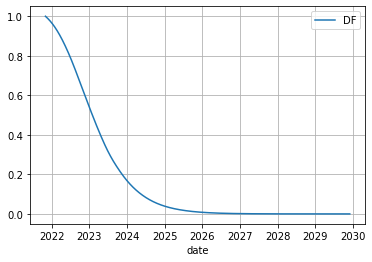

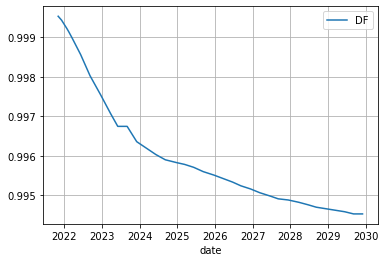

In [7]:
pd.DataFrame(interp[0]).rename(columns={0:'date', 1:'DF'}).plot(x=0, y=1, grid=True)
pd.DataFrame(interp[1]).rename(columns={0:'date', 1:'DF'}).plot(x=0, y=1, grid=True)
plt.show()